In [159]:
import networkx as nx
# import urllib -- Did not work on my linux machine - using requests instead
import re
import tqdm
import collections
import requests
#import community.community_louvain as cl
import json
import matplotlib.pyplot as plt
import pandas as pd
import copy
import re
import numpy as np

In [2]:
D = nx.read_graphml('directed.graphml')

In [120]:
f = open('dates_dict.json')
dates_dict = json.load(f)

f = open('long_lat_dict.json')
long_lat_dict = json.load(f)


In [12]:
for n in D.nodes():
    if n in dates_dict.keys():
        D.nodes[n]['origin_time'] = dates_dict.get(n)
    if n in long_lat_dict.keys():
        D.nodes[n]['origin_location'] = long_lat_dict.get(n)
    

In [21]:
D.nodes['Korean court music']['origin_location']

[38.233686649999996, 127.00873073371443]

In [25]:
D_loc = D.subgraph(list(long_lat_dict.keys()))

In [26]:
D_loc

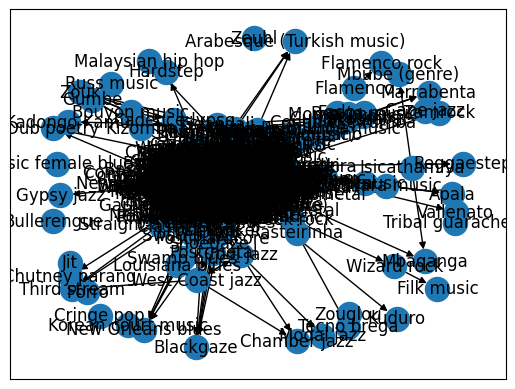

In [27]:
nx.draw_networkx(D_loc)

In [32]:
loc = {}
for x in D_loc.nodes: 
    loc[x] =  D_loc.nodes[x]['origin_location']

In [45]:
pos = {genre: (v[1], v[0])
       for genre, v in
       loc.items()}

In [46]:
import cartopy.crs as ccrs

/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


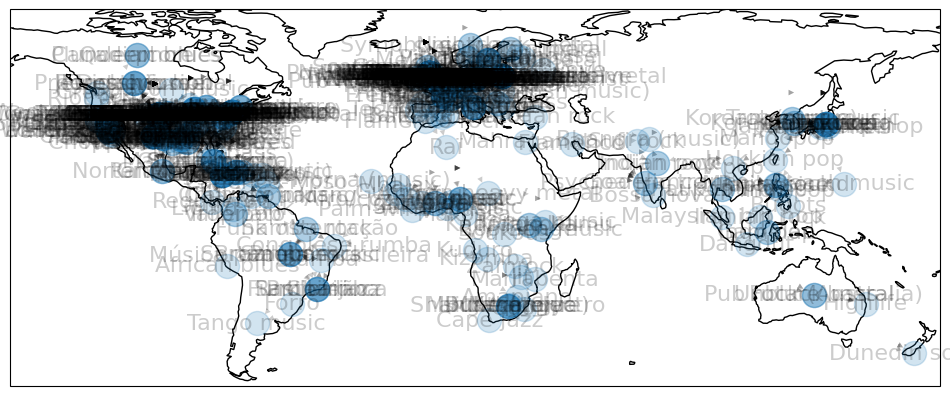

In [47]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
#ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(D_loc, ax=ax,
                 font_size=16,
                 alpha=.2,
                 width=.001,
                 #node_size=sizes,
                 #labels=labels,
                 pos=pos,
                 #node_color=altitude,
                 cmap=plt.cm.autumn)

In [48]:
import folium

In [50]:
nodes = D_loc.nodes
edges = D_loc.edges

In [57]:
# Create a folium map centered around the mean latitude and longitude
mean_lat = sum(node['origin_location'][0] for node in nodes.values()) / len(nodes)
mean_lon = sum(node['origin_location'][1] for node in nodes.values()) / len(nodes)


In [162]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4)

# Add nodes to the map
for node, data in nodes.items():
    folium.CircleMarker(location=[data['origin_location'][0], data['origin_location'][1]],
                        popup=node, 
                        color='black',
                        fill=True,
                        size = float(np.log(1 +D_loc.in_degree[node])),
                        opacity=0.5, 
                        fill_opacity=0.1).add_to(m)

# Add edges to the map
for edge in edges:
    start, end = edge
    start_latlon = (nodes[start]['origin_location'][0], nodes[start]['origin_location'][1])
    end_latlon = (nodes[end]['origin_location'][0], nodes[end]['origin_location'][1])
    folium.PolyLine([start_latlon, end_latlon],
                    color="gray", 
                    opacity=0.1,
                   ).add_to(m)

# Save the map as an HTML file
m.save('network_map.html')

# nodes as locations (to much noise) 

In [211]:
mapping = {}
for x in nodes: 
    mapping[x] = tuple(D_loc.nodes[x]['origin_location'])

In [212]:
start_end_loc = []
all_locs = []
for s, e in edges: 
    start_end_loc.append((mapping[s], mapping[e]))    
    all_locs.append(mapping[s])
    all_locs.append(mapping[e])
    

In [213]:
start_end_loc = set(start_end_loc)

In [228]:
(-33.928992, 18.417396) in set(all_locs)

False

In [229]:
reverse_mapping = dict().fromkeys(set(all_locs))
for k in reverse_mapping.keys():
    reverse_mapping[k] = []
    
for k, v in mapping.items(): 
    try:
        reverse_mapping[v].append(k)
    except:
        pass # nodes without edges

In [233]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4)

# Add nodes to the map
for node, data in nodes.items():
    try: 
        folium.CircleMarker(location=[data['origin_location'][0], data['origin_location'][1]],
                            popup=", ".join(reverse_mapping[(data['origin_location'][0], data['origin_location'][1])]), 
                            color='#9000de',
                            fill_color='#9000de',
                            fill=True,
                            radius = float(np.log(1 + D_loc.in_degree[node])),
                            opacity=0.2, 
                            fill_opacity=0.2).add_to(m)
    except: 
        pass # fails for nodes without edges
# Add edges to the map
for start, end in start_end_loc:
    folium.PolyLine([start, end],
                    color="#9000de", 
                    opacity=0.8,
                    weight=0.2,
                   ).add_to(m)

# Save the map as an HTML file
m.save('network_map_2.html')

# Just nodes 

In [67]:
names = list(nodes)
lat = [node['origin_location'][0] for node in nodes.values()]
long = [node['origin_location'][1] for node in nodes.values()]


In [74]:
in_degrees = [x for y, x in list(D_loc.in_degree)]

In [75]:
df = pd.DataFrame(
    dict(
        lat = lat,
        long=long,
        name=names,
        degree = in_degrees
    )
)

In [79]:
import plotly.express as px

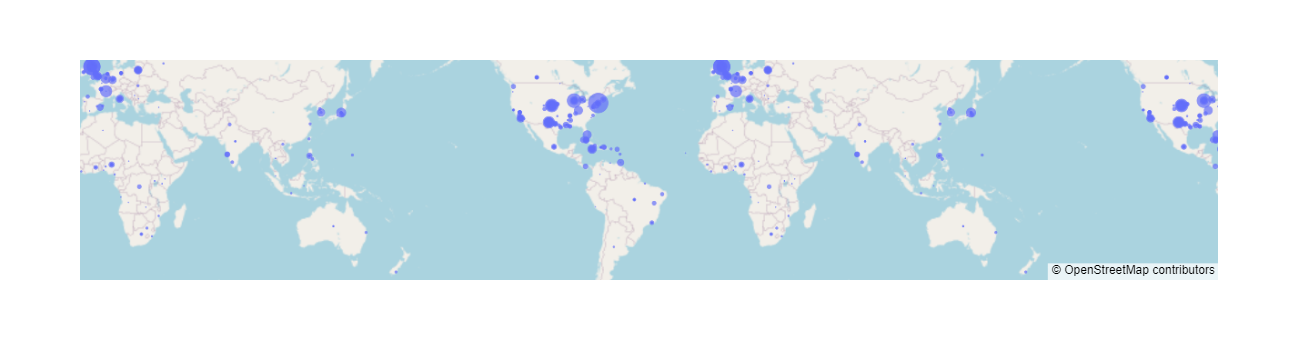

In [140]:
# plottly
scatter_mapbox = px.scatter_mapbox(
    df,
    lat="lat",
    lon="long",
    size="degree",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    hover_name="name",
    mapbox_style="open-street-map",
    zoom=1,
)
scatter_mapbox.show()

In [121]:
time = pd.DataFrame().from_dict(dates_dict, orient='index').reset_index()

In [133]:
time.columns = ['name', 'time']
time['time'] = time['time'].astype(int)

In [134]:
time['time'] = time.time.round(10) # make it decades 

In [135]:
time = time.sort_values('time')[3:] # get outliers out 

In [141]:
df = df.merge(time, on = 'name')

In [147]:
df = df.sort_values('time')

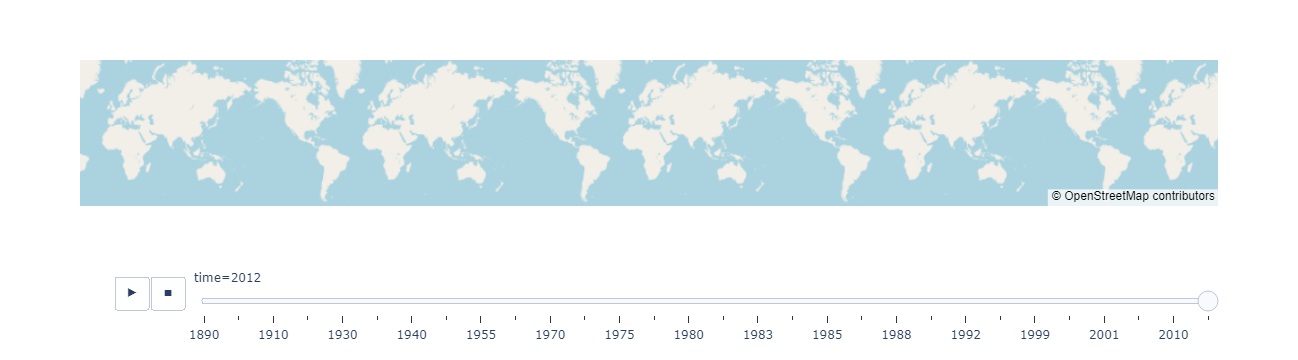

In [149]:
# plottly
scatter_mapbox = px.scatter_mapbox(
    df,
    lat="lat",
    lon="long",
    size="degree",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    hover_name="name",
    mapbox_style="open-street-map",
    zoom=1,
    animation_frame='time',
    animation_group='name'
)
scatter_mapbox.show()